# LeNet-5手写体识别

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt

## 数据

In [2]:
trans_train = transforms.Compose([
    # 随机翻转
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    #归一化
    transforms.Normalize((0.1307,),(0.3081,))    
])
trans_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
#下载数据集
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=trans_train)
test_set = datasets.MNIST(root="./data", train=False, download=True, transform=trans_test)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

## 网络结构

In [3]:
# LeNet-5结构
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        # 向量展平
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
#定义GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
#优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
#训练过程
def train_runner(model, device, trainloader, optimizer, epoch):
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # ! 数据需要和模型在相同的device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        outputs = model(inputs)
        #交叉熵损失
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        # 分类正确了多少？
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 1000 == 0:
            #loss.item()表示当前loss的数值
            print("Epoch{} \t Loss: {:.6f}, 正确率: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

In [6]:
#测试过程
def test_runner(model, device, testloader):
    model.eval()
    #统计模型正确率
    correct = 0.0
    test_loss = 0.0
    total = 0
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()

        print("平均损失: {:.6f}, 正确率: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 训练入口

In [8]:
# 入口
epoch = 5
Loss = []
Accuracy = []
best_acc = -1000
for epoch in range(1, epoch+1):
    print("开始时间",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    # 保存最佳模型
    if acc > best_acc:
        torch.save(model, './models/model-mnist.pth')
        print('最优模型路径:', './models/model-mnist.pth')
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    
    print("结束时间: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('done')
# plt.subplot(2,1,1)
# plt.plot(Loss)
# plt.title('Loss')
# plt.show()
# plt.subplot(2,1,2)
# plt.plot(Accuracy)
# plt.title('Accuracy')
# plt.show()

开始时间 2023-04-10 23:02:04
Epoch1 	 Loss: 2.312547, 正确率: 9.375000%
最优模型路径: ./models/model-mnist.pth
平均损失: 0.003913, 正确率: 96.080000%
结束时间:  2023-04-10 23:02:27 

开始时间 2023-04-10 23:02:27
Epoch2 	 Loss: 0.078142, 正确率: 95.312500%
最优模型路径: ./models/model-mnist.pth
平均损失: 0.002167, 正确率: 97.720000%
结束时间:  2023-04-10 23:02:48 

开始时间 2023-04-10 23:02:48
Epoch3 	 Loss: 0.038341, 正确率: 98.437500%
最优模型路径: ./models/model-mnist.pth
平均损失: 0.001900, 正确率: 98.060000%
结束时间:  2023-04-10 23:03:09 

开始时间 2023-04-10 23:03:09
Epoch4 	 Loss: 0.059755, 正确率: 98.437500%
最优模型路径: ./models/model-mnist.pth
平均损失: 0.002033, 正确率: 97.950000%
结束时间:  2023-04-10 23:03:30 

开始时间 2023-04-10 23:03:30
Epoch5 	 Loss: 0.014408, 正确率: 100.000000%
最优模型路径: ./models/model-mnist.pth
平均损失: 0.001998, 正确率: 98.110000%
结束时间:  2023-04-10 23:03:50 

done


### 查看效果

(1, 32, 32)
(32, 32, 1)


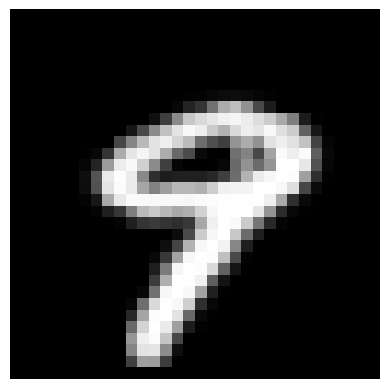

概率： tensor([[7.0485e-43, 2.0739e-43, 2.4290e-26, 1.3876e-28, 2.9577e-09, 3.2027e-25,
         5.3249e-44, 4.8450e-15, 4.4343e-22, 1.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
预测类别： 9


In [20]:
import cv2
import torch
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/model-mnist.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # img = cv2.imread("./images/test_mnist.jpg")
    img = test_set[9][0].numpy()
    print(img.shape)
    # 转化成opencv能处理的维度
    img = np.transpose(img, [1,2,0])
    print(img.shape)
    img=cv2.resize(img,dsize=(32,32),interpolation=cv2.INTER_NEAREST)
    plt.imshow(img,cmap="gray") # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    img = trans(img)
    img = img.to(device)
    #图片扩展多一维batch
    img = img.unsqueeze(0)
   
    # 预测 
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    print("预测类别：",predict.item())

